In [1]:
from time import sleep
from gpiozero import DigitalOutputDevice
from datetime import datetime
from dataclasses import dataclass
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]

In [2]:
try:
    from max31855 import MAX31855
except ImportError:
    print("Stubbing MAX31855 & Power")
    class MAX31855:
        stubbed = True
        def getTemperature(self):
            return 75
    class DigitalOutputDevice:
        stubbed = True
        def __init__(self, pin, initial_value):
            self.value = initial_value
        def on(self):
            self.value = True
        def off(self):
            self.value = False

In [3]:
class queue:
    def __init__(self, depth):
        self.depth = depth
        self.queue = []

    def __getitem__(self, key):
        try:
            return self.queue[key]
        except:
            return None

    def __call__(self, value):
        self.queue.insert(0, value)
        while len(self.queue) > self.depth:
            self.queue.pop()

In [4]:
class KilnDrone:
    def __init__(self):
        self.targetTemp = 0

        self.cycleCount = 0
        self.cycleTime = 0.1

        self.tempProbe = MAX31855()
    
        self.tempMemoryDepth = 60000
        self.tempMemory = queue(self.tempMemoryDepth)
        self.tempMemory(self.temperature)
        
        self.setPower = 0
        self.setPowerMemory = queue(60000)
        self.currentPower = 0
        self.powerStep = 0.01
        self.powerWindow = 0.5

        self.power = DigitalOutputDevice(pin="GPIO17", initial_value=False)
        self.powerMemoryDepth = 60000
        self.powerOnMemory = queue(self.powerMemoryDepth)
        self.powerMemory = queue(self.powerMemoryDepth)
        
        self.restrictPowerChangeUntil = 0
        self.restrictPowerStepChangeUntil = 0
        
        self.extendObservations(70)
    
    @property
    def filteredTemp(self):
        window = 10
        fT = []
        for i in range(0, len(self.tempMemory.queue) - window, window):
            selected = sorted(self.tempMemory.queue[i:i + window])[int(window / 2)]
            fT.extend([selected for i in range(window)])
        return fT[:self.tempMemoryDepth]
    
    @property
    def temperature(self):
        return self.tempProbe.getTemperature()
    
    def getCurrentPower(self):
        return (sum(self.powerOnMemory.queue) / len(self.powerOnMemory.queue)) * 100
    
    def startObservation(self):
        self.observationStart = self.cycleCount
    
    @dataclass
    class ObservationsCharacter:
        temperature: float
        target: float
        power: float
        setPower: float
        powerStep: float
        slope: float
        error: float

    def characterizeObservations(self, start=None, stop=None):
        start = 0 if start is None else start
        stop = 1000 if stop is None else stop
        obs = self.filteredTemp[start:stop]
        delta = stop - start
        error = ((self.targetTemp - obs[0]) / (self.targetTemp if self.targetTemp != 0 else 1/10000)) * 100
        slope = obs[0] - obs[-1]
        char = self.ObservationsCharacter(**{
            "temperature": obs[0],
            "target": self.targetTemp,
            "power": self.getCurrentPower(),
            "setPower": self.setPower,
            "powerStep": self.powerStep,
            "slope": slope,
            "error": error
        })
        return char
    
    def tune(self):
        if self.targetTemp < 80:
            print("Kiln Disabled")
            self.setPower = 0
            return
        elif self.power.value:
            return

        try:
            obChar = self.characterizeObservations(stop=30)
            prevObChar = self.characterizeObservations(start=30, stop=60)
        except IndexError:
            print("Insufficient observations")
            raise
            return
        print(f"Tuning: {self}")

        accel = (obChar.slope + prevObChar.slope) / 2
        Foresight = obChar.temperature + 3 * (obChar.slope + accel)
        
        if obChar.error < 0.01:
            print("Cutting Power")
            self.setPower = 0
        elif Foresight > self.targetTemp:
            print("Preemptively Cutting Power")
            self.setPower = 0
        elif obChar.error > 0 and accel <= 0.01:
            if self.cycleCount > self.restrictPowerChangeUntil and prevObChar.slope <= 0:
                print("Add Energy")
                self.setPower = obChar.power + self.powerStep
                self.restrictPowerChangeUntil = self.cycleCount + 50

        self.setPower = max(min(self.setPower, 50), 0)
        print(f"Accel: {accel:7.4}. Foresight: {Foresight:7.4}. Tuned power to {self.setPower}")

    def observe(self):
        self.setPowerMemory(self.setPower)
        self.powerMemory(self.getCurrentPower())
        self.powerOnMemory(self.power.value)
        self.tempMemory(self.temperature)
    
    def extendObservations(self, n):
        self.setPowerMemory.queue = [self.setPower for i in range(n)] + self.setPowerMemory.queue
        self.powerOnMemory.queue = [self.power.value for i in range(n)] + self.powerOnMemory.queue
        
        pMValue = self.getCurrentPower()
        self.powerMemory.queue = [pMValue for i in range(n)] + self.powerMemory.queue
        
        currentTemp = self.temperature
        self.tempMemory.queue = [currentTemp for i in range(n)] + self.tempMemory.queue
    
    def render(self, cyclesAgo=6000):
        startTime = datetime.utcnow()
        if self.power.value:
            print("Can't render while powering")
            return
        
        print(f"Summary:\nMaxTemp: {max(self.filteredTemp)} | MinTemp: {min(self.filteredTemp)}")

        fig, ax = plt.subplots()
        ax.set_xlabel("Cycles Ago")
        ax2 = ax.twinx()
        ln2 = ax.plot([self.targetTemp for i in self.tempMemory.queue[:cyclesAgo]], color="blue", label="Target Temperature")
        ln1 = ax.plot(self.filteredTemp[:cyclesAgo], color="green", label="Temperature")
        ax.set_ylabel("Temperature (*F)")
        ln4 = ax2.plot(self.setPowerMemory.queue[:cyclesAgo], color="darkred", label="Set Power")
        ln3 = ax2.plot(self.powerOnMemory.queue[:cyclesAgo], color="red", label="Power Impulse")
        ln5 = ax2.plot(self.powerMemory.queue[:cyclesAgo], color="turquoise", label="Power")
        ax2.set_ylabel("Power Duty Cycle")
        lines = ln1 + ln2 + ln3 + ln4 + ln5
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc="upper right")
        plt.title("Temperature and Power over Time")
        plt.show()
        renderTime = datetime.utcnow() - startTime
        self.extendObservations(int(renderTime.total_seconds() / self.cycleTime))

    def processPower(self):
        if self.power.value:
            self.power.off()
        else:
            if self.getCurrentPower() < min(self.setPower, 50):
                self.power.on()
            else:
                self.power.off()
    
    def cycle(self):
        sleep(self.cycleTime)
        self.cycleCount += 1
        self.observe()
        self.processPower()
        self.tune()
    
    def __repr__(self):
        return f"{datetime.utcnow()} || At Cycle {self.cycleCount % 10000:<4} (Resisting power changes until {self.restrictPowerChangeUntil % 10000:<4})" \
            f"\n{self.characterizeObservations()}"

In [5]:
k = KilnDrone()

Tuning: 2021-09-21 03:56:39.906656 || At Cycle 1    (Resisting power changes until 0   )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.0, setPower=0, powerStep=0.01, slope=0.0, error=47.1)
Add Energy
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:56:39.915329 || At Cycle 1    (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.0, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:56:40.641204 || At Cycle 3    (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=1.36986301369863, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:56:41.052816 || At Cycle 4    (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=1.

Tuning: 2021-09-21 03:56:51.185980 || At Cycle 30   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=1.0, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:56:51.582380 || At Cycle 31   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.9900990099009901, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:56:51.955381 || At Cycle 32   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.9803921568627451, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:56:52.352059 || At Cycle 33   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200,

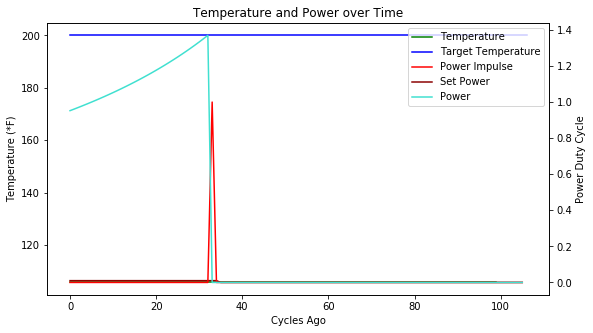

Tuning: 2021-09-21 03:57:00.613968 || At Cycle 37   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.5847953216374269, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:57:00.986816 || At Cycle 38   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.5813953488372093, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:57:01.384413 || At Cycle 39   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.5780346820809248, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.01
Tuning: 2021-09-21 03:57:01.815200 || At Cycle 40   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105

Tuning: 2021-09-21 03:57:11.604355 || At Cycle 65   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=106.25, target=200, power=0.5025125628140703, setPower=0.01, powerStep=0.01, slope=0.45000000000000284, error=46.875)
Accel:   0.225. Foresight:   108.3. Tuned power to 0.01
Tuning: 2021-09-21 03:57:12.005589 || At Cycle 66   (Resisting power changes until 51  )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.5, setPower=0.01, powerStep=0.01, slope=0.0, error=47.1)
Add Energy
Accel:     0.0. Foresight:   105.8. Tuned power to 0.51
Tuning: 2021-09-21 03:57:12.769946 || At Cycle 68   (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.9900990099009901, setPower=0.51, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.51
Tuning: 2021-09-21 03:57:13.176011 || At Cycle 69   (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(

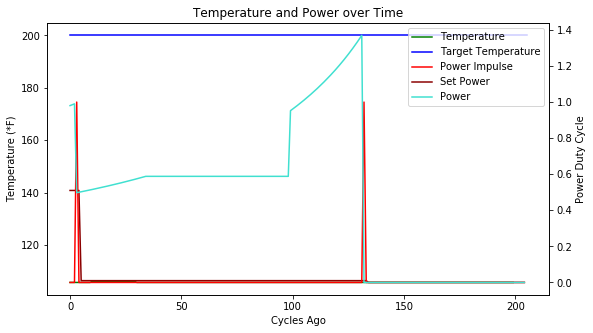

Tuning: 2021-09-21 03:57:20.412456 || At Cycle 72   (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.7575757575757576, setPower=0.51, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.51
Tuning: 2021-09-21 03:57:20.808003 || At Cycle 73   (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.7547169811320755, setPower=0.51, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.51
Tuning: 2021-09-21 03:57:21.186675 || At Cycle 74   (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=105.8, target=200, power=0.7518796992481203, setPower=0.51, powerStep=0.01, slope=0.0, error=47.1)
Accel:     0.0. Foresight:   105.8. Tuned power to 0.51
Tuning: 2021-09-21 03:57:21.583737 || At Cycle 75   (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=105

Tuning: 2021-09-21 03:57:31.424104 || At Cycle 100  (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=106.7, target=200, power=0.684931506849315, setPower=0.51, powerStep=0.01, slope=0.9000000000000057, error=46.65)
Accel:     0.0. Foresight:   106.7. Tuned power to 0.51
Tuning: 2021-09-21 03:57:31.819518 || At Cycle 101  (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=106.7, target=200, power=0.6825938566552902, setPower=0.51, powerStep=0.01, slope=0.9000000000000057, error=46.65)
Accel:     0.0. Foresight:   106.7. Tuned power to 0.51
Tuning: 2021-09-21 03:57:32.197906 || At Cycle 102  (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=106.7, target=200, power=0.6802721088435374, setPower=0.51, powerStep=0.01, slope=0.9000000000000057, error=46.65)
Accel:     0.0. Foresight:   106.7. Tuned power to 0.51
Tuning: 2021-09-21 03:57:32.607336 || At Cycle 103  (Resisting power changes until 116 )


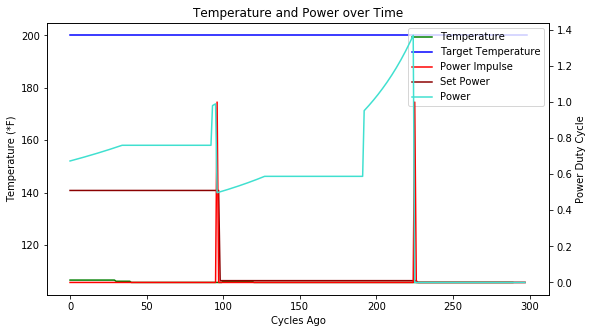

Tuning: 2021-09-21 03:57:40.851641 || At Cycle 107  (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=106.7, target=200, power=0.5509641873278237, setPower=0.51, powerStep=0.01, slope=0.9000000000000057, error=46.65)
Accel:     0.0. Foresight:   106.7. Tuned power to 0.51
Tuning: 2021-09-21 03:57:41.275240 || At Cycle 108  (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=106.7, target=200, power=0.5494505494505495, setPower=0.51, powerStep=0.01, slope=0.9000000000000057, error=46.65)
Accel:     0.0. Foresight:   106.7. Tuned power to 0.51
Tuning: 2021-09-21 03:57:41.656456 || At Cycle 109  (Resisting power changes until 116 )
KilnDrone.ObservationsCharacter(temperature=106.7, target=200, power=0.547945205479452, setPower=0.51, powerStep=0.01, slope=0.9000000000000057, error=46.65)
Accel:     0.0. Foresight:   106.7. Tuned power to 0.51
Tuning: 2021-09-21 03:57:42.057401 || At Cycle 110  (Resisting power changes until 116 )


Tuning: 2021-09-21 03:57:51.510863 || At Cycle 134  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.15, target=200, power=0.7692307692307693, setPower=0.5461930294906167, powerStep=0.01, slope=1.3500000000000085, error=46.425)
Accel:   0.225. Foresight:   109.2. Tuned power to 0.5461930294906167
Tuning: 2021-09-21 03:57:51.916505 || At Cycle 135  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.15, target=200, power=0.7672634271099744, setPower=0.5461930294906167, powerStep=0.01, slope=1.3500000000000085, error=46.425)
Accel:   0.225. Foresight:   109.2. Tuned power to 0.5461930294906167
Tuning: 2021-09-21 03:57:52.338824 || At Cycle 136  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.15, target=200, power=0.7653061224489796, setPower=0.5461930294906167, powerStep=0.01, slope=1.3500000000000085, error=46.425)
Accel:   0.225. Foresight:   109.2. Tuned power to 0.546193029490616

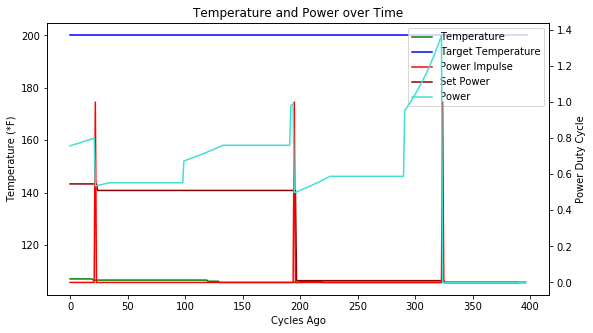

Tuning: 2021-09-21 03:58:01.288470 || At Cycle 142  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.15, target=200, power=0.6507592190889371, setPower=0.5461930294906167, powerStep=0.01, slope=1.3500000000000085, error=46.425)
Accel:     0.0. Foresight:   107.2. Tuned power to 0.5461930294906167
Tuning: 2021-09-21 03:58:01.712898 || At Cycle 143  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.15, target=200, power=0.6493506493506493, setPower=0.5461930294906167, powerStep=0.01, slope=1.3500000000000085, error=46.425)
Accel:     0.0. Foresight:   107.2. Tuned power to 0.5461930294906167
Tuning: 2021-09-21 03:58:02.093140 || At Cycle 144  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.15, target=200, power=0.6479481641468683, setPower=0.5461930294906167, powerStep=0.01, slope=1.3500000000000085, error=46.425)
Accel:     0.0. Foresight:   107.2. Tuned power to 0.546193029490616

Tuning: 2021-09-21 03:58:10.860209 || At Cycle 166  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.60000000000001, target=200, power=0.6185567010309279, setPower=0.5461930294906167, powerStep=0.01, slope=1.8000000000000114, error=46.199999999999996)
Accel:   0.225. Foresight:   109.6. Tuned power to 0.5461930294906167
Tuning: 2021-09-21 03:58:11.260835 || At Cycle 167  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.60000000000001, target=200, power=0.6172839506172839, setPower=0.5461930294906167, powerStep=0.01, slope=1.8000000000000114, error=46.199999999999996)
Accel:   0.225. Foresight:   109.6. Tuned power to 0.5461930294906167
Tuning: 2021-09-21 03:58:11.640526 || At Cycle 168  (Resisting power changes until 167 )
KilnDrone.ObservationsCharacter(temperature=107.60000000000001, target=200, power=0.6160164271047228, setPower=0.5461930294906167, powerStep=0.01, slope=1.8000000000000114, error=46.1999999999999

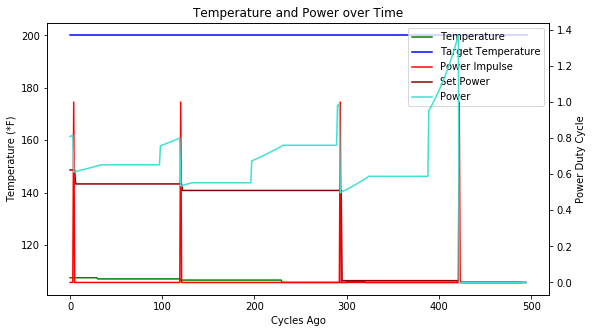

Tuning: 2021-09-21 03:58:21.421005 || At Cycle 177  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=109.4, target=200, power=0.7194244604316548, setPower=0.6234969325153374, powerStep=0.01, slope=3.6000000000000085, error=45.3)
Accel:     0.0. Foresight:   109.4. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:21.804433 || At Cycle 178  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=109.4, target=200, power=0.718132854578097, setPower=0.6234969325153374, powerStep=0.01, slope=3.6000000000000085, error=45.3)
Accel:     0.0. Foresight:   109.4. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:22.228015 || At Cycle 179  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=109.4, target=200, power=0.7168458781362007, setPower=0.6234969325153374, powerStep=0.01, slope=3.6000000000000085, error=45.3)
Accel:     0.0. Foresight:   109.4. Tuned power to 0.6234969325153374
Tuning: 

Tuning: 2021-09-21 03:58:31.823610 || At Cycle 203  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.5, target=200, power=0.6872852233676976, setPower=0.6234969325153374, powerStep=0.01, slope=2.700000000000003, error=45.75)
Accel:     0.0. Foresight:   108.5. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:32.227320 || At Cycle 204  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.5, target=200, power=0.6861063464837049, setPower=0.6234969325153374, powerStep=0.01, slope=2.700000000000003, error=45.75)
Accel:   0.225. Foresight:   110.5. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:32.612685 || At Cycle 205  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.5, target=200, power=0.684931506849315, setPower=0.6234969325153374, powerStep=0.01, slope=2.700000000000003, error=45.75)
Accel:   0.225. Foresight:   110.5. Tuned power to 0.6234969325153374
Tuning: 

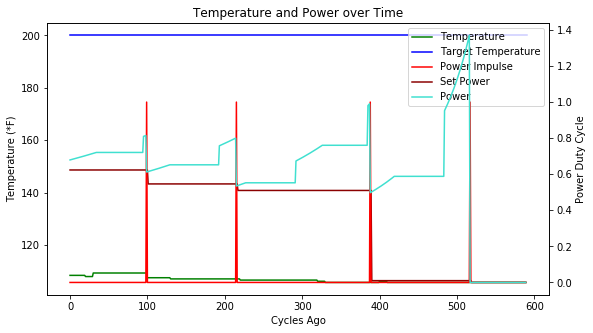

Tuning: 2021-09-21 03:58:42.139917 || At Cycle 213  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.5, target=200, power=0.7668711656441718, setPower=0.6234969325153374, powerStep=0.01, slope=2.700000000000003, error=45.75)
Accel:     0.0. Foresight:   108.5. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:42.532102 || At Cycle 214  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.5, target=200, power=0.7656967840735069, setPower=0.6234969325153374, powerStep=0.01, slope=2.700000000000003, error=45.75)
Accel:     0.0. Foresight:   108.5. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:42.939177 || At Cycle 215  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.5, target=200, power=0.764525993883792, setPower=0.6234969325153374, powerStep=0.01, slope=2.700000000000003, error=45.75)
Accel:     0.0. Foresight:   108.5. Tuned power to 0.6234969325153374
Tuning: 

Tuning: 2021-09-21 03:58:52.120530 || At Cycle 238  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.95, target=200, power=0.7385524372230428, setPower=0.6234969325153374, powerStep=0.01, slope=3.1500000000000057, error=45.525)
Accel:   0.225. Foresight:   111.0. Tuned power to 0.6234969325153374
Tuning: 2021-09-21 03:58:52.537116 || At Cycle 239  (Resisting power changes until 220 )
KilnDrone.ObservationsCharacter(temperature=108.95, target=200, power=0.7374631268436578, setPower=0.6234969325153374, powerStep=0.01, slope=3.1500000000000057, error=45.525)
Add Energy
Accel:     0.0. Foresight:   109.0. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:58:53.311568 || At Cycle 241  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=108.95, target=200, power=0.8823529411764706, setPower=0.7474631268436578, powerStep=0.01, slope=3.1500000000000057, error=45.525)
Accel:     0.0. Foresight:   109.0. Tuned power to 0.7474

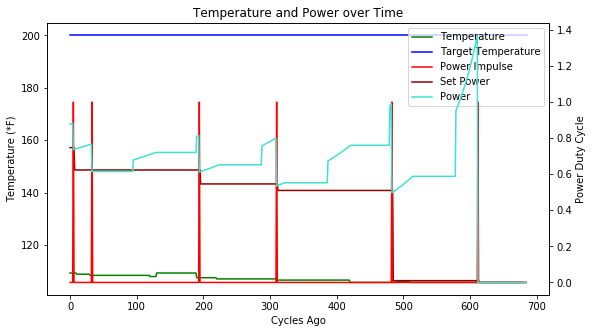

Tuning: 2021-09-21 03:59:02.252083 || At Cycle 247  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=109.85000000000001, target=200, power=0.8021390374331552, setPower=0.7474631268436578, powerStep=0.01, slope=4.050000000000011, error=45.074999999999996)
Accel:     0.0. Foresight:   109.9. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:02.643638 || At Cycle 248  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=109.85000000000001, target=200, power=0.801068090787717, setPower=0.7474631268436578, powerStep=0.01, slope=4.050000000000011, error=45.074999999999996)
Accel:     0.0. Foresight:   109.9. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:03.071831 || At Cycle 249  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=109.85000000000001, target=200, power=0.8, setPower=0.7474631268436578, powerStep=0.01, slope=4.050000000000011, error=45.074999999999996)
Accel:     0.0.

Tuning: 2021-09-21 03:59:12.322487 || At Cycle 272  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=110.75, target=200, power=0.7761966364812419, setPower=0.7474631268436578, powerStep=0.01, slope=4.950000000000003, error=44.625)
Accel:    0.45. Foresight:   114.8. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:12.713726 || At Cycle 273  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=110.75, target=200, power=0.7751937984496124, setPower=0.7474631268436578, powerStep=0.01, slope=4.950000000000003, error=44.625)
Accel:    0.45. Foresight:   114.8. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:13.122781 || At Cycle 274  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=110.75, target=200, power=0.7741935483870968, setPower=0.7474631268436578, powerStep=0.01, slope=4.950000000000003, error=44.625)
Accel:    0.45. Foresight:   114.8. Tuned power to 0.7474631268436578
T

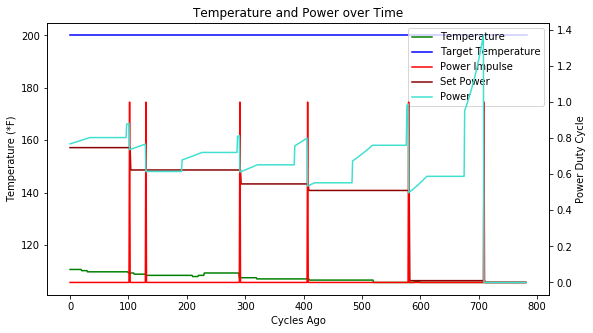

Tuning: 2021-09-21 03:59:23.274087 || At Cycle 283  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=110.75, target=200, power=0.8264462809917356, setPower=0.7474631268436578, powerStep=0.01, slope=4.950000000000003, error=44.625)
Accel:     0.0. Foresight:   110.8. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:23.703029 || At Cycle 284  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=110.75, target=200, power=0.8254716981132075, setPower=0.7474631268436578, powerStep=0.01, slope=4.950000000000003, error=44.625)
Accel:     0.0. Foresight:   110.8. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:24.093798 || At Cycle 285  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=110.75, target=200, power=0.8244994110718492, setPower=0.7474631268436578, powerStep=0.01, slope=4.950000000000003, error=44.625)
Accel:     0.0. Foresight:   110.8. Tuned power to 0.7474631268436578
T

Tuning: 2021-09-21 03:59:33.350193 || At Cycle 308  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=111.65, target=200, power=0.8027522935779817, setPower=0.7474631268436578, powerStep=0.01, slope=5.8500000000000085, error=44.175)
Accel:   0.225. Foresight:   113.7. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:33.786884 || At Cycle 309  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=111.65, target=200, power=0.8018327605956471, setPower=0.7474631268436578, powerStep=0.01, slope=5.8500000000000085, error=44.175)
Accel:   0.225. Foresight:   113.7. Tuned power to 0.7474631268436578
Tuning: 2021-09-21 03:59:34.175929 || At Cycle 310  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=111.65, target=200, power=0.8009153318077803, setPower=0.7474631268436578, powerStep=0.01, slope=5.8500000000000085, error=44.175)
Accel:   0.225. Foresight:   113.7. Tuned power to 0.747463126843657

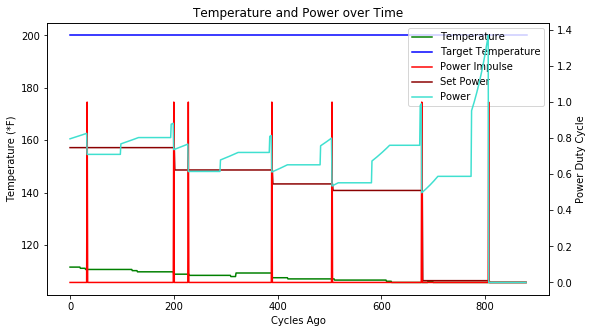

Tuning: 2021-09-21 03:59:43.527920 || At Cycle 318  (Resisting power changes until 289 )
KilnDrone.ObservationsCharacter(temperature=112.10000000000001, target=200, power=0.8501594048884166, setPower=0.7474631268436578, powerStep=0.01, slope=6.300000000000011, error=43.949999999999996)
Add Energy
Accel:     0.0. Foresight:   112.1. Tuned power to 0.8601594048884166
Tuning: 2021-09-21 03:59:44.312199 || At Cycle 320  (Resisting power changes until 368 )
KilnDrone.ObservationsCharacter(temperature=112.10000000000001, target=200, power=0.9544008483563097, setPower=0.8601594048884166, powerStep=0.01, slope=6.300000000000011, error=43.949999999999996)
Accel:     0.0. Foresight:   112.1. Tuned power to 0.8601594048884166
Tuning: 2021-09-21 03:59:44.744062 || At Cycle 321  (Resisting power changes until 368 )
KilnDrone.ObservationsCharacter(temperature=112.10000000000001, target=200, power=0.9533898305084746, setPower=0.8601594048884166, powerStep=0.01, slope=6.300000000000011, error=43.94999

In [ ]:
try:
    k.targetTemp = 200
    renderWindow = 35
    nextRender = renderWindow
    clearWindow = 3000
    nextClear = clearWindow
    k.cycleCount = 0
    k.cycle()
    k.tune()
    while True:
        k.cycle()
        if k.cycleCount > nextClear:
            nextClear = k.cycleCount + clearWindow - (k.cycleCount % clearWindow)
            clear_output(wait=False)
            k.render(cyclesAgo=60000)
        elif k.cycleCount > nextRender:
            nextRender = k.cycleCount + renderWindow - (k.cycleCount % renderWindow)
            k.render()
finally:
    k.power.off()

In [ ]:
k.power.off()

In [ ]:
k.observe()
k.render()